In [ ]:
# use TensorFlow decision forests to predict customer churn

In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
import math

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import tensorflow_decision_forests as tfdf

import matplotlib.pyplot as plt

##### helper functions

##### load dataset

In [3]:
# load dataset
dataset = pd.read_csv("dataset.csv", low_memory = False)

# dataset.shape

print("{} examples, and {} features in the dataset".format(
    dataset.shape[0], dataset.shape[1]))

413955 examples, and 37 features in the dataset


In [4]:
dataset.columns

Index(['subscription_id', 'observation_dt', 'is_retained', 'specialization_id',
       'cnt_courses_in_specialization', 'specialization_domain',
       'is_professional_certificate', 'is_gateway_certificate',
       'learner_days_since_registration', 'learner_country_group',
       'learner_gender', 'learner_cnt_other_courses_active',
       'learner_cnt_other_courses_paid_active',
       'learner_cnt_other_courses_items_completed',
       'learner_cnt_other_courses_paid_items_completed',
       'learner_cnt_other_transactions_past', 'learner_other_revenue',
       'subscription_period_order', 'days_since_last_payment',
       'days_til_next_payment_due',
       'cnt_enrollments_started_before_payment_period',
       'cnt_enrollments_completed_before_payment_period',
       'cnt_enrollments_active_before_payment_period',
       'cnt_items_completed_before_payment_period',
       'cnt_graded_items_completed_before_payment_period',
       'is_subscription_started_with_free_trial',
      

In [5]:
# remove NA values
dataset = dataset.dropna()
sum(dataset.isnull().sum())

0

In [6]:
# drop id and time features
drop_features = ["subscription_id", "observation_dt", "specialization_id"]

dataset = dataset.drop(columns = drop_features)

In [7]:
dataset.dtypes

is_retained                                         float64
cnt_courses_in_specialization                       float64
specialization_domain                                object
is_professional_certificate                          object
is_gateway_certificate                               object
learner_days_since_registration                     float64
learner_country_group                                object
learner_gender                                       object
learner_cnt_other_courses_active                    float64
learner_cnt_other_courses_paid_active               float64
learner_cnt_other_courses_items_completed           float64
learner_cnt_other_courses_paid_items_completed      float64
learner_cnt_other_transactions_past                 float64
learner_other_revenue                               float64
subscription_period_order                           float64
days_since_last_payment                             float64
days_til_next_payment_due               

In [8]:
# transform boolean columns into string type

bool_cols = ["is_professional_certificate", "is_gateway_certificate", "is_active_capstone_during_pay_period", 
             "is_subscription_started_with_free_trial", "is_active_capstone_during_pay_period"]

for column in bool_cols:
#     print(column)
    dataset[column] = dataset[column].astype(str)

In [9]:
dataset["is_retained"] = dataset["is_retained"].astype(int)

In [10]:
# balanced dataset?
# what percent of the data represents the positive class

sum(dataset["is_retained"]) / dataset.shape[0] * 100

54.36631694902562

### Training a Random Forest model

In [11]:
# split dataset into training, validation and test sets

random_state = 1234

label = "is_retained"

train_ds_pd, val_ds_pd = train_test_split(dataset, test_size = 0.4, random_state = random_state)
val_ds_pd, test_ds_pd = train_test_split(val_ds_pd, test_size = 0.5, random_state = random_state)

In [14]:
print("{} examples in training, {} examples for validation, {} examples for testing.".format(
    train_ds_pd.shape[0], val_ds_pd.shape[0], test_ds_pd.shape[0]))

248371 examples in training, 82791 examples for validation, 82791 examples for testing.


In [15]:
# convert the pandas dataframe into tensorflow datasets

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(val_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

#### train and evaluate the model

In [16]:
trees = range(50, 1050, 50)
type(trees[0])

int

In [21]:
def trainRandomForest(tf_dataset, n_trees, max_depth):
    
    model = tfdf.keras.RandomForestModel(num_trees = n_trees, max_depth = max_depth, verbose = 0, 
                                        compute_oob_variable_importances = True)
    
    model.fit(tf_dataset)
    
    return model


def computeMetrics(model, val_dataset, label):
 
    # evaluate the model
    evaluation = model.predict(val_dataset)

    # predicted probabilities of subscription renewal
    predicted_probs = evaluation.flatten()


    predictions = (predicted_probs > 0.5).astype(int)
    
    metrics = {
        "accuracy": accuracy_score(val_ds_pd[label], predictions),
        "precision": precision_score(val_ds_pd[label], predictions),
        "recall": recall_score(val_ds_pd[label], predictions),
        "f1": f1_score(val_ds_pd[label], predictions),
        "roc_auc": roc_auc_score(val_ds_pd[label], predictions),
    }
    
    return metrics

 
# specify the model

# model_1 = tfdf.keras.RandomForestModel(num_trees = 50, max_depth = 16, verbose = 2, 
#                                        compute_oob_variable_importances = True)

# train the model
# model_1.fit(train_ds)

In [22]:
accuracy = []
precision = []
recall = []
f1 = []
roc_auc = []

for tree in trees:
    
    model = trainRandomForest(train_ds, tree, max_depth = 16)
    
    print("trained forest with {} trees".format(tree))
    
    metrics = computeMetrics(model, val_ds, label)
    
    accuracy.append((tree, metrics["accuracy"]))
    precision.append((tree, metrics["precision"]))
    recall.append((tree, metrics["recall"]))
    f1.append((tree, metrics["f1"]))
    roc_auc.append((tree, metrics["roc_auc"]))
    
    

[INFO 24-04-30 15:07:20.1359 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmphxz4uvb0/model/ with prefix ab026115bd7f4d64
[INFO 24-04-30 15:07:21.4079 EDT decision_forest.cc:734] Model loaded with 50 root(s), 517174 node(s), and 33 input feature(s).
[INFO 24-04-30 15:07:21.4080 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:07:21.4080 EDT kernel.cc:1061] Use fast generic engine


trained forest with 50 trees
83/83 [==============================] - 2s 27ms/step


[INFO 24-04-30 15:10:57.3742 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpq3qa1s4a/model/ with prefix 46fb34ca8a5f427c
[INFO 24-04-30 15:11:00.0984 EDT decision_forest.cc:734] Model loaded with 100 root(s), 1042346 node(s), and 33 input feature(s).
[INFO 24-04-30 15:11:00.0984 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:11:00.0984 EDT kernel.cc:1061] Use fast generic engine


trained forest with 100 trees
83/83 [==============================] - 2s 27ms/step


[INFO 24-04-30 15:16:26.9185 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpa4eh7itr/model/ with prefix 50f70013aa0f4a2c
[INFO 24-04-30 15:16:30.6605 EDT decision_forest.cc:734] Model loaded with 150 root(s), 1558600 node(s), and 33 input feature(s).
[INFO 24-04-30 15:16:30.6605 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:16:30.6606 EDT kernel.cc:1061] Use fast generic engine


trained forest with 150 trees
83/83 [==============================] - 3s 34ms/step


[INFO 24-04-30 15:23:29.2653 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpc31qfeqk/model/ with prefix 4fb8d70708a4428f
[INFO 24-04-30 15:23:34.2165 EDT decision_forest.cc:734] Model loaded with 200 root(s), 2066842 node(s), and 33 input feature(s).
[INFO 24-04-30 15:23:34.2165 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:23:34.2166 EDT kernel.cc:1061] Use fast generic engine


trained forest with 200 trees
83/83 [==============================] - 4s 50ms/step


[INFO 24-04-30 15:31:57.9592 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmplmvvcb7p/model/ with prefix c27f26216e7e47e2
[INFO 24-04-30 15:32:04.1361 EDT decision_forest.cc:734] Model loaded with 250 root(s), 2585618 node(s), and 33 input feature(s).
[INFO 24-04-30 15:32:04.1361 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:32:04.1361 EDT kernel.cc:1061] Use fast generic engine


trained forest with 250 trees
83/83 [==============================] - 5s 63ms/step


[INFO 24-04-30 15:42:02.9768 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpeqaadnyc/model/ with prefix b9ca8d2931334de6
[INFO 24-04-30 15:42:10.2846 EDT decision_forest.cc:734] Model loaded with 300 root(s), 3115072 node(s), and 33 input feature(s).
[INFO 24-04-30 15:42:10.2847 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:42:10.2847 EDT kernel.cc:1061] Use fast generic engine


trained forest with 300 trees
83/83 [==============================] - 7s 85ms/step


[INFO 24-04-30 15:53:43.1877 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpo0ee3p97/model/ with prefix 66666ae2e253422b
[INFO 24-04-30 15:53:51.7516 EDT decision_forest.cc:734] Model loaded with 350 root(s), 3628918 node(s), and 33 input feature(s).
[INFO 24-04-30 15:53:51.7516 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 15:53:51.7516 EDT kernel.cc:1061] Use fast generic engine


trained forest with 350 trees
83/83 [==============================] - 9s 102ms/step


[INFO 24-04-30 16:06:51.6703 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpm6dyp8dr/model/ with prefix abbec12c7b764df1
[INFO 24-04-30 16:07:01.5865 EDT decision_forest.cc:734] Model loaded with 400 root(s), 4148506 node(s), and 33 input feature(s).
[INFO 24-04-30 16:07:01.5866 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 16:07:01.5866 EDT kernel.cc:1061] Use fast generic engine


trained forest with 400 trees
83/83 [==============================] - 8s 101ms/step


[INFO 24-04-30 16:21:27.0989 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp9etog2aq/model/ with prefix a5866d76733f4838
[INFO 24-04-30 16:21:38.2219 EDT decision_forest.cc:734] Model loaded with 450 root(s), 4673788 node(s), and 33 input feature(s).
[INFO 24-04-30 16:21:38.2220 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 16:21:38.2220 EDT kernel.cc:1061] Use fast generic engine


trained forest with 450 trees
83/83 [==============================] - 9s 111ms/step


[INFO 24-04-30 16:37:42.7087 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp3uu2o7hr/model/ with prefix 5b8fc906c4dc4876
[INFO 24-04-30 16:37:55.0515 EDT decision_forest.cc:734] Model loaded with 500 root(s), 5193590 node(s), and 33 input feature(s).
[INFO 24-04-30 16:37:55.0515 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 16:37:55.0516 EDT kernel.cc:1061] Use fast generic engine


trained forest with 500 trees
83/83 [==============================] - 10s 123ms/step


[INFO 24-04-30 16:55:53.6634 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpdhs83sbp/model/ with prefix 11c36a4b728a414b
[INFO 24-04-30 16:56:07.3733 EDT decision_forest.cc:734] Model loaded with 550 root(s), 5707908 node(s), and 33 input feature(s).
[INFO 24-04-30 16:56:07.3733 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 16:56:07.3734 EDT kernel.cc:1061] Use fast generic engine


trained forest with 550 trees
83/83 [==============================] - 13s 156ms/step


[INFO 24-04-30 17:15:52.2992 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpxrb7dsao/model/ with prefix 06259be5f2404c88
[INFO 24-04-30 17:16:07.3958 EDT decision_forest.cc:734] Model loaded with 600 root(s), 6231280 node(s), and 33 input feature(s).
[INFO 24-04-30 17:16:07.3958 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 17:16:07.3959 EDT kernel.cc:1061] Use fast generic engine


trained forest with 600 trees
83/83 [==============================] - 14s 164ms/step


[INFO 24-04-30 17:37:31.3680 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp4vg8rvvd/model/ with prefix 4053541e0bbd45f7
[INFO 24-04-30 17:37:47.9073 EDT decision_forest.cc:734] Model loaded with 650 root(s), 6753718 node(s), and 33 input feature(s).
[INFO 24-04-30 17:37:47.9073 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 17:37:47.9074 EDT kernel.cc:1061] Use fast generic engine


trained forest with 650 trees
83/83 [==============================] - 15s 185ms/step


[INFO 24-04-30 18:00:35.3021 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp0jx9zaph/model/ with prefix 37354aaca34c4083
[INFO 24-04-30 18:00:53.2853 EDT decision_forest.cc:734] Model loaded with 700 root(s), 7276770 node(s), and 33 input feature(s).
[INFO 24-04-30 18:00:53.2853 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 18:00:53.2854 EDT kernel.cc:1061] Use fast generic engine


trained forest with 700 trees
83/83 [==============================] - 16s 189ms/step


[INFO 24-04-30 18:25:14.1814 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp3nbiuj7i/model/ with prefix 25d9b80d7cf4498e
[INFO 24-04-30 18:25:33.0408 EDT decision_forest.cc:734] Model loaded with 750 root(s), 7799354 node(s), and 33 input feature(s).
[INFO 24-04-30 18:25:33.0409 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 18:25:33.0409 EDT kernel.cc:1061] Use fast generic engine


trained forest with 750 trees
83/83 [==============================] - 17s 208ms/step


[INFO 24-04-30 18:51:46.4273 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp4bkxm1d0/model/ with prefix d36e172d410348aa
[INFO 24-04-30 18:52:06.6836 EDT decision_forest.cc:734] Model loaded with 800 root(s), 8319112 node(s), and 33 input feature(s).
[INFO 24-04-30 18:52:06.6837 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 18:52:06.6837 EDT kernel.cc:1061] Use fast generic engine


trained forest with 800 trees
83/83 [==============================] - 19s 231ms/step


[INFO 24-04-30 19:19:45.9985 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp7rb3u7z3/model/ with prefix 1f90ca3bb38a40eb
[INFO 24-04-30 19:20:07.6590 EDT decision_forest.cc:734] Model loaded with 850 root(s), 8845822 node(s), and 33 input feature(s).
[INFO 24-04-30 19:20:07.6590 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 19:20:07.6590 EDT kernel.cc:1061] Use fast generic engine


trained forest with 850 trees
83/83 [==============================] - 19s 233ms/step


[INFO 24-04-30 19:49:04.5678 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmp77r9g15f/model/ with prefix 1e0eebc76e4b4ca7
[INFO 24-04-30 19:49:27.0945 EDT decision_forest.cc:734] Model loaded with 900 root(s), 9366382 node(s), and 33 input feature(s).
[INFO 24-04-30 19:49:27.0946 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 19:49:27.0946 EDT kernel.cc:1061] Use fast generic engine


trained forest with 900 trees
83/83 [==============================] - 21s 252ms/step


[INFO 24-04-30 20:20:28.8070 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmpwws0n7xb/model/ with prefix 24fc01dea48748d5
[INFO 24-04-30 20:20:52.8674 EDT decision_forest.cc:734] Model loaded with 950 root(s), 9882462 node(s), and 33 input feature(s).
[INFO 24-04-30 20:20:52.8675 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 20:20:52.8675 EDT kernel.cc:1061] Use fast generic engine


trained forest with 950 trees
83/83 [==============================] - 23s 271ms/step


[INFO 24-04-30 20:53:39.0444 EDT kernel.cc:1233] Loading model from path /var/folders/sc/c663j6bx65391kdjgk7jy_d00000gn/T/tmplcs_4peg/model/ with prefix 6c74189be58a4cb1
[INFO 24-04-30 20:54:04.3262 EDT decision_forest.cc:734] Model loaded with 1000 root(s), 10398788 node(s), and 33 input feature(s).
[INFO 24-04-30 20:54:04.3262 EDT abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-04-30 20:54:04.3263 EDT kernel.cc:1061] Use fast generic engine


trained forest with 1000 trees
83/83 [==============================] - 25s 299ms/step


In [44]:
accuracy_plot = [a for _, a in accuracy]
precision_plot = [a for _, a in precision]
recall_plot = [a for _, a in recall]
f1_plot = [a for _, a in f1]
roc_auc_plot = [a for _, a in roc_auc]

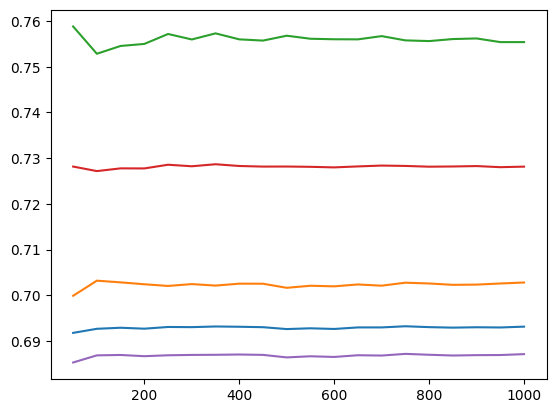

In [45]:
plt.plot(trees, accuracy_plot)
plt.plot(trees, precision_plot)
plt.plot(trees, recall_plot)
plt.plot(trees, f1_plot)
plt.plot(trees, roc_auc_plot)

plt.show()

In [24]:
model.summary()

Model: "random_forest_model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (33):
	cnt_courses_in_specialization
	cnt_days_active_before_payment_period
	cnt_days_active_during_payment_period
	cnt_days_since_last_activity
	cnt_enrollments_active_before_payment_period
	cnt_enrollments_active_during_payment_period
	cnt_enrollments_completed_before_payment_period
	cnt_enrollments_completed_during_payment_period
	cnt_enrollments_started_before_payment_period
	cnt_enrollments_started_during_payment_period
	cnt_graded_items_completed_before_payment_period
	cnt_graded_items_completed_during_payment_period
	cnt_items_completed_before_payment_period
	cnt_items_completed_durin

In [47]:
metrics = {
    "trees": [a for a, _ in accuracy],
    "accuracy": [a for _, a in accuracy],
    "precision": [a for _, a in precision],
    "recall": [a for _, a in recall],
    "f1": [a for _, a in f1],
    "roc_auc": [a for _, a in roc_auc],
}

In [52]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,trees,accuracy,precision,recall,f1,roc_auc
0,50,0.691766,0.699887,0.758825,0.728166,0.685288
1,100,0.692660,0.703191,0.752853,0.727175,0.686845
2,150,0.692889,0.702821,0.754562,0.727773,0.686932
3,200,0.692684,0.702406,0.755006,0.727757,0.686664
4,250,0.693058,0.702038,0.757182,0.728568,0.686864
5,300,0.693022,0.702445,0.755983,0.728231,0.686940
6,350,0.693167,0.702118,0.757315,0.728673,0.686971
7,400,0.693107,0.702538,0.756006,0.728292,0.687031
8,450,0.693010,0.702522,0.755739,0.728159,0.686951
9,500,0.692599,0.701630,0.756805,0.728174,0.686397


In [53]:
metrics_df.to_csv("prediction_data/rf_ntrees_test.csv", index = False)